# Работа с тремя новыми наборами данных
---

## Загрузка и знакомство с данными

Подгрузим модули и библиотеки.

In [1]:
# Для работы с числами и таблицами
import numpy as np
import pandas as pd
# Для подгрузки ранее сохраненных в файл данных
import joblib
# Обработка предупреждений
import warnings

# Модули sklearn для работы с данными
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import model_selection
from sklearn import metrics
from sklearn import inspection
from sklearn import naive_bayes
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors
from sklearn import neural_network
from sklearn import tree
from sklearn import ensemble
from sklearn import kernel_approximation

# Оконная функция для обработки данных
from scipy import signal

# Бустинг-модели
import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

# Для оптимизации моделей
import optuna

# Инструменты визуализации
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# Progress bar
from tqdm import tqdm
# Для таймеров
import time

### Утилиты ввода-вывода
#### Данные

In [2]:
# Сформируем список из путей до каждого из трех файлов с данными
palm_files = [
    './data/data_three_sets/2024-03-04_08-17-49.emg8',
    './data/data_three_sets/2024-03-04_10-00-21.emg8',
    './data/data_three_sets/2024-03-04_11-11-02.emg8'
]

# Выбираем индекс файла [0, 1, 2]
file_idx = 0
palm_file = palm_files[file_idx] # передаем путь к файлу переменной
# Подгружаем таблицу с данными
gestures = pd.read_csv(palm_file, sep=' ', on_bad_lines='skip')
# Далее мы избавляемся от начального и конечного участков записи данных
gestures = gestures[~gestures['state'].isin(['Baseline', 'Finish'])]
# ...и разбираемся со смещенными индексами
gestures.sort_index(inplace=True)
gestures.reset_index(drop=True, inplace=True)

print('Data shape:', gestures.shape)
gestures.head()

Data shape: (6364, 56)


,ts,td,0,1,2,3,4,5,6,7,...,44,45,46,47,48,49,prot,state,id,now
0,96392.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.02
1,96425.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.05
2,96458.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.08
3,96491.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.12
4,96524.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.15


Как видим, в таблице имеются сведения о времени (`ts`, `td`), где `td` — это, разумеется, delta t, и он всегда один и тот же. `prot` сообщает о номере совершаемого действия. `state` — положение руки (какой жест исполняется). `id` и `now` — сведения об индексе жеста и времени.

Нас интересуют пронумерованные столбцы — там и находится информация, поступавшая из ОМГ-датчиков.

In [3]:
OMG_CH = np.arange(50).astype(str)
# [X features] '0', ..., '49' - каналы OMG датчиков
# 'ts' - метка времени
gestures.columns

Index(['ts', 'td', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', 'prot', 'state', 'id', 'now'],
      dtype='object')

Можем посмотреть на панораму данных.

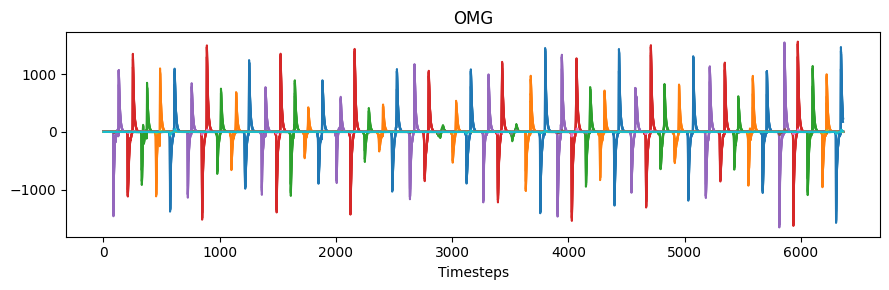

In [4]:
fig = plt.figure(figsize=(9, 3))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

In [5]:
# Зафиксируем данные за переменной
X = gestures[OMG_CH].values

# Перекодируем классы жестов
le = preprocessing.LabelEncoder()
state = gestures['state'].values
y_cmd = le.fit_transform(state)

display(np.c_[le.transform(le.classes_), le.classes_])

print(X.shape, y_cmd.shape)

array([[0, 'Close'],
       [1, 'Indication'],
       [2, 'Neutral'],
       [3, 'Open'],
       [4, 'Pinch'],
       [5, 'ThumbFingers']], dtype=object)

(6364, 50) (6364,)


In [6]:
GESTURES = le.classes_
GESTURES

array(['Close', 'Indication', 'Neutral', 'Open', 'Pinch', 'ThumbFingers'],
      dtype=object)

Выведем данные и таргет.

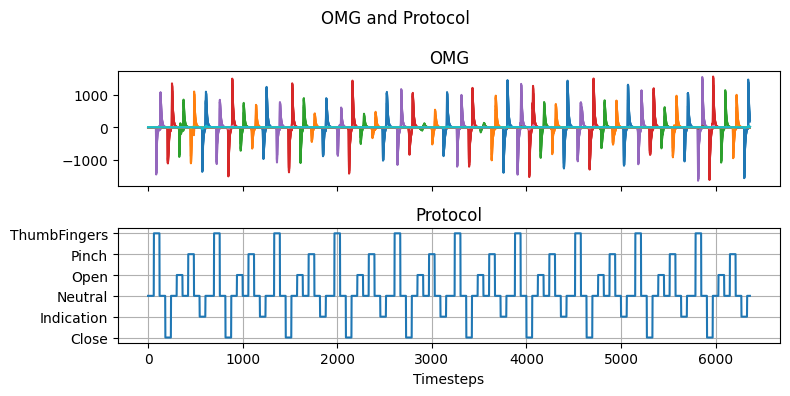

In [7]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

---
## Предобработка данных

#### Функция для визуализации

In [8]:
def get_graphs(X_array, y_array, start=1000, end=1500):
    """Функция для отрисовки графики "OMG and Protocol"
    для заданного интервала

    Args:
        X_array (ndarray): массив данных.
        y_array (ndarray): вектор таргета.
        start (int, optional): стартовая точка данных
        визуализируемого интервала. Defaults to 1000.
        end (int, optional): конечная точка данных
        визуализируемого интервала. Defaults to 1500.
    """
    
    _, ax1 = plt.subplots(sharex=True, figsize=(15, 3))
    plt.suptitle(f'OMG and Protocol {start}:{end}')
    ax1.plot(X_array[start:end])
    ax1.set_xlabel('Timesteps')
    ax1.set_ylabel('OMG')
    plt.grid(axis='x')
    ax2 = ax1.twinx()
    ax2.plot(y_array[start:end], 'b-')
    ax2.set_ylabel('y_cmd')
    plt.yticks(np.arange(len(GESTURES)), GESTURES)
    plt.show()

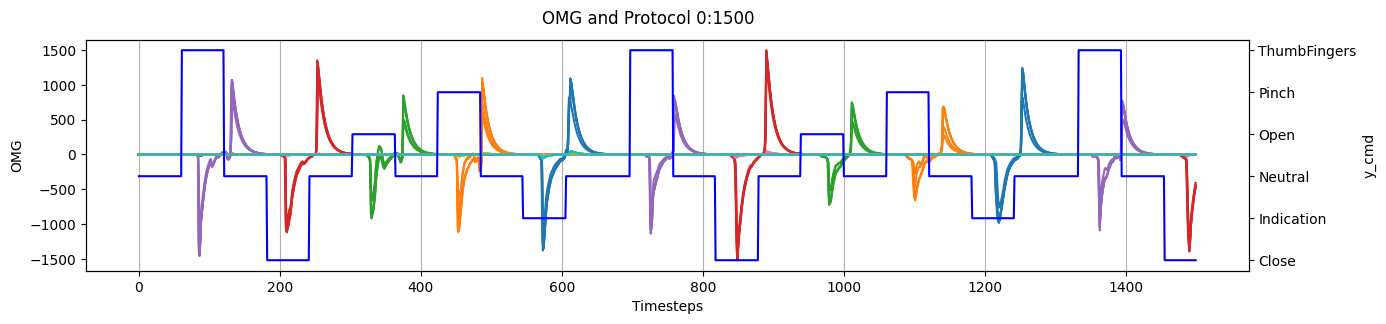

In [9]:
get_graphs(gestures[OMG_CH].values, y_cmd, start=0, end=1500)

Здесь, как и в прошлые разы, мы видим смещение данных относительно таргета. Этой особенностью, очевидно, обладают данные всех трех сетов.

#### Функция для устранение лага между сигналами датчиков и таргетом

In [10]:
def get_naive_centering(X_arr, y_arr, gap=500, inter=1000, window=20, use_m=True, model=svm.SVC()):
    """Функция для устранения глобального лага между сигналами датчиков и таргетом.

    Args:
        X_arr (ndarray): Массив данных.
        y_arr (ndarray): Вектор целевого признака.
        gap (int, optional): Размеры концевых отступов. Defaults to 500.
        inter (int, optional): Величина концевых выборок. Defaults to 1000.
        window (int, optional): Величина окна поиска оптимального сдвига. Defaults to 20.
        use_m (bool, optional): Использование модели для поиска оптимального сдвига.
            Defaults to True. False: поиск сдвига по корреляции таргета с вектором
            суммы модулей дифференциалов векторов признаков массива данных.
        model (_type_, optional): Алгоритм scikit-learn. Defaults to svm.SVC().

    Returns:
        tuple():
            ndarray: Вектор сдвинутого таргета.
            list: Строки отчета по проделанным операциям.
    """
    # part of the data from the beginning
    X_part1 = X_arr[gap:gap+inter]
    y_part1 = y_arr[gap:gap+inter]
    # part of the data from the end
    X_part2 = X_arr[-gap-inter:-gap]
    y_part2 = y_arr[-gap-inter:-gap]
    
    # Функция для сдвига таргета
    def shifter(y_arr, shift=1):
        first_element = y_arr[0]
        prefix = np.full(shift, first_element)
        y_arr_shifted = np.concatenate((prefix, y_arr))[:-shift]
    
        return y_arr_shifted
    
    # Функция для расчета точности модели
    def get_score(X, y, model=model):
        model.fit(X, y)
        preds = model.predict(X)
        
        return metrics.accuracy_score(y, preds)
    
    # Функция для расчета корреляции
    def get_corr(X, y):
        x_diff = pd.DataFrame(X).diff().abs().sum(axis=1)
        correlation = np.corrcoef(x_diff, y)[0, 1]
        
        return abs(correlation)
    
    
    max_score1, current_score1 = 0, 0
    max_score2, current_score2 = 0, 0
    s1, s2 = 1, 1
    
    for i in range(1, window+1):
        y_a = shifter(y_part1, shift=i)
        y_b = shifter(y_part2, shift=i)
        
        if use_m:
            current_score1 = get_score(X_part1, y_a)
            current_score2 = get_score(X_part2, y_b)
        else:
            current_score1 = get_corr(X_part1, y_a)
            current_score2 = get_corr(X_part2, y_b)
        
        if current_score1 > max_score1:
            max_score1, current_score1 = current_score1, max_score1
            s1 = i
        
        if current_score2 > max_score2:
            max_score2, current_score2 = current_score2, max_score2
            s2 = i
    
    optimal_shift = round((s1+s2)/2)
    y_arr_shifted = shifter(y_arr, shift=optimal_shift)
    summary = [
        f'Оптимальные свдиги для концевых выборок:   {s1} и {s2}\n',
        f'Accuracy/correlation на концевых выборках: {max_score1}; {max_score2}\n',
        f'Размер оптимального сдвига (как среднего): {optimal_shift}'
    ]
    
    return y_arr_shifted, summary

### Сэмплирование

Здесь мы начнем накапливать сэмплы для тестирования данных. Для этого мы напишем специальную функцию, которая подгрузит данные (1), избавится от сдвига таргета (2), сформирует выборки данных (3) и разместит их в словаре (4). Всего будет три словаря — по числу сетов.

Важно попытаться сохранить равное представительство классов жестов внутри каждой из выборок, т.е. число каждого вида жестов внутри выборки долнжо быть одинаковым. Для данных из третьего сета соотношение 80/20 не подходит, поэтому там был подобран индекс отсечения.

In [11]:
def get_dict_with_data(file_path):
    """Функция для загрузки данных и помещения их в словарь.

    Args:
        file_path (str): путь до файла

    Returns:
        dict: словарь 
    """
    # Создадим словарь 
    dictionary = dict()
    OMG_CH = np.arange(50).astype(str)
    # Подгружаем таблицу с данными
    data = pd.read_csv(file_path, sep=' ', on_bad_lines='skip')
    # Далее мы избавляемся от начального и конечного участков записи данных
    data = data[~data['state'].isin(['Baseline', 'Finish'])]
    # ...и разбираемся со смещенными индексами
    data.sort_index(inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    # Зафиксируем данные за переменной
    X = data[OMG_CH].values

    # Перекодируем классы жестов
    le = preprocessing.LabelEncoder()
    state = data['state'].values
    y_cmd = le.fit_transform(state)
    
    y_shifted, _ = get_naive_centering(X, y_cmd, gap=20, inter=100, window=30, use_m=False)
    
    if '2024-03-04_11-11-02' not in file_path:
        X_train = X[:int(X.shape[0] * 0.8)+1]
        X_valid = X[int(X.shape[0] * 0.8)+1:]

        y_train = y_shifted[:int(X.shape[0] * 0.8)+1]
        y_valid = y_shifted[int(X.shape[0] * 0.8)+1:]
    else:
        X_train = X[:1950]
        X_valid = X[1950:]

        y_train = y_shifted[:1950]
        y_valid = y_shifted[1950:]
    
    # Занесем в словарь наши данные
    key = 'original_data'
    dictionary[key] = [X_train, X_valid, y_train, y_valid]

    return dictionary

Создадим три словаря и соберем их в список, а затем распечатаем shapы данных под ключами словарей.

In [53]:
dictionary_0 = get_dict_with_data(palm_files[0])
dictionary_1 = get_dict_with_data(palm_files[1])
dictionary_2 = get_dict_with_data(palm_files[2])

dictionaries = [dictionary_0, dictionary_1, dictionary_2]

for dictionary in dictionaries:
    for key in list(dictionary.keys()):
        print(f"{str(key).capitalize().replace('_', ' ')} shapes:")
        print('Train:', dictionary[key][0].shape, dictionary[key][2].shape)
        print('Test: ', dictionary[key][1].shape, dictionary[key][3].shape)
        print()

Original data shapes:
Train: (5092, 50) (5092,)
Test:  (1272, 50) (1272,)

Original data shapes:
Train: (5092, 50) (5092,)
Test:  (1272, 50) (1272,)

Original data shapes:
Train: (1950, 50) (1950,)
Test:  (595, 50) (595,)



### Оценка доли нулей

В этом подразделе осуществляется визуализация нулевых строк в данных и подсчет их доли в признаках. Это может быть полезным, если мы желаем предварительно оценить вклад признаков в предсказания обучаемых моделей.

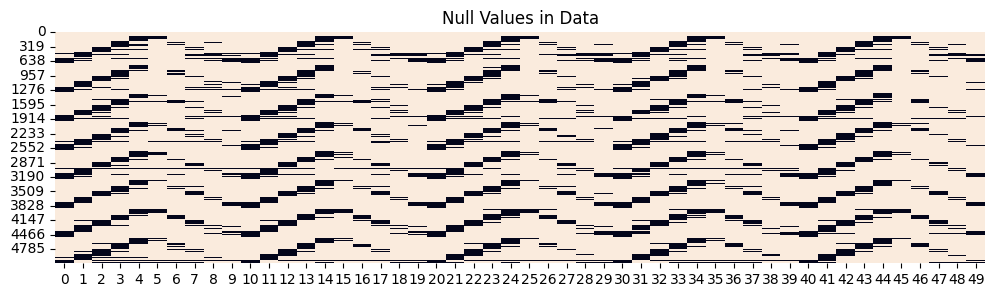

In [35]:
def get_null_map(dict_idx):
    """Функция для визуализации нулей в данных

    Args:
        dict_idx (int): индекс словаря в списке.
    """
    null_detect = pd.DataFrame(
        dictionaries[dict_idx]['original_data'][0],columns=[*OMG_CH]
    ).replace(0, np.nan)

    # Создадим тепловую карту для визуализации 0-значений
    plt.figure(figsize=(12, 3))
    sns.heatmap(null_detect.isna(), cbar=False)
    plt.title('Null Values in Data')
    plt.show()
    

get_null_map(0)

Очень интересное распределение нулей в данных. Мы видим, что ненулевые строки коррелируют с сериями жестов, а признаки поделились на пять групп, по паре признаков в которых *реагируют* только на свои жесты.

Любопытно, но подобная картина наблюдается только для первого сета.

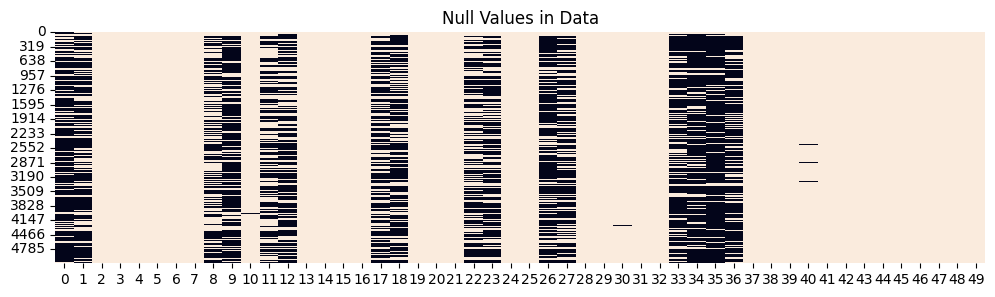

In [36]:
get_null_map(1)

Это второй сет, где, как мы видим, присутствуют полностью обнуленные признаки. Забегая вперед, отметим, что этот сет хуже всего поддается моделированию.

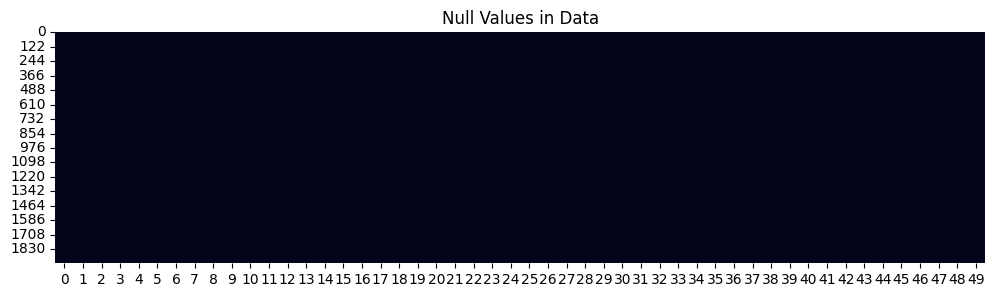

In [37]:
get_null_map(2)

Это третий сет, и в нем ни единого нуля.

### Нормализация и стандартизация

In [54]:
# Инициализируем методы нормализации и стандартизации
normalizer = preprocessing.Normalizer()
rb_scaler = preprocessing.RobustScaler()
mm_scaler = preprocessing.MinMaxScaler()
st_scaler = preprocessing.StandardScaler()
scalers = [normalizer, rb_scaler, mm_scaler, st_scaler]
prfix_list = ['_norm', '_rb', '_mm', '_st']

# Занесем в каждый словарь предобработанные версии данных
for dictionary in dictionaries:
    for key in list(dictionary.keys()):
        train_y = dictionary[key][2]
        test_y = dictionary[key][3]
        
        for i, scaler in enumerate(scalers):
            X_train_scaled = scaler.fit_transform(dictionary[key][0])
            X_test_scaled = scaler.transform(dictionary[key][1])
            new_key = f'data{prfix_list[i]}'
            dictionary[new_key] = [
                X_train_scaled, X_test_scaled,
                dictionary[key][2], dictionary[key][3]
            ]

Выведем новые наборы ключей.

In [55]:
for dictionary in dictionaries:
    print(dictionary.keys())

dict_keys(['original_data', 'data_norm', 'data_rb', 'data_mm', 'data_st'])
dict_keys(['original_data', 'data_norm', 'data_rb', 'data_mm', 'data_st'])
dict_keys(['original_data', 'data_norm', 'data_rb', 'data_mm', 'data_st'])


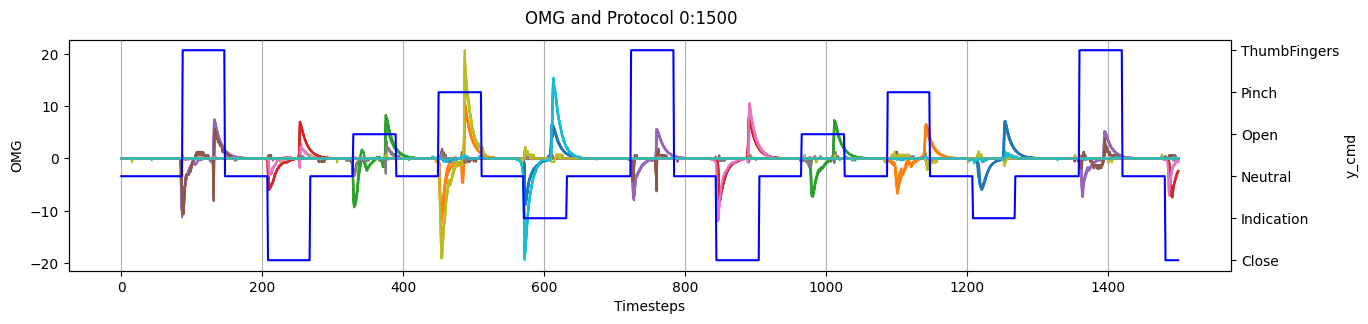

In [40]:
get_graphs(
    dictionaries[0][list(dictionaries[0].keys())[-1]][0],
    dictionaries[0][list(dictionaries[0].keys())[-1]][2],
    start=0, end=1500
)

### Генерация признаков
#### Аппроксимирующая модель линейной регрессии

In [41]:
def get_approx_lr_coefs(X, n_ftrs=10, prev=None, lin_alg=None):
    """Функция для формирования признакового описания 
       с использованием линейной регрессии

    Args:
        X (ndarray): массив данных.
        n_ftrs (int, optional): размер сэмпла. Defaults to 10.
        prev (ndarray, optional): предшествующие данные размером n_ftrs.
        Defaults to None.
        lin_alg (abc.ABCMeta, optional): линейный алгоритм sklearn.
        По умолчанию используется алгоритм МНК из numpy.

    Returns:
        ndarray: массив коэффициентов модели регрессии.
    """
    
    def get_coefs(data):
        # Разделение данных на признаки и целевую переменную
        segments_X = data[1:, :].T
        segments_y = data[0, :]
        
        # Обучение модели линейной регрессии
        if lin_alg is not None:
            model = lin_alg()
            model.fit(segments_X, segments_y)
            # Получение параметров модели
            return model.coef_
        else:
            w = np.linalg.lstsq(segments_X, segments_y, rcond=None)[0]
            # Вектор весов линейной функции
            return w
        
    
    w_g = np.zeros((0, n_ftrs))
    window = np.zeros((n_ftrs+1, X.shape[-1]))
    if prev is not None:
        window[1:, :] = prev
    
    for i in range(X.shape[0]):
        if not np.sum(window[0]):
            window[0, :] = X[i]
        else:
            window[1:, :] = window[:-1, :]
            window[0, :] = X[i]

        coefs = get_coefs(window)
        w_g = np.vstack((w_g, coefs))
    
    return w_g

In [56]:
# Занесем в каждый словарь предобработанные версии данных
for dictionary in dictionaries:
    for key in tqdm(list(dictionary.keys()), desc="Processed"):
        train_y = dictionary[key][2]
        test_y = dictionary[key][3]
        
        X_train_ax = get_approx_lr_coefs(dictionary[key][0])
        X_test_ax = get_approx_lr_coefs(dictionary[key][1])
        
        new_key = key + '_ax'
        dictionary[new_key] = (X_train_ax, X_test_ax, train_y, test_y)

Processed: 100%|██████████| 5/5 [00:00<00:00, 14.41it/s]


In [57]:
for dictionary in dictionaries:
    print(list(dictionary.keys())[:-5])
    print(list(dictionary.keys())[-5:])

['original_data', 'data_norm', 'data_rb', 'data_mm', 'data_st']
['original_data_ax', 'data_norm_ax', 'data_rb_ax', 'data_mm_ax', 'data_st_ax']
['original_data', 'data_norm', 'data_rb', 'data_mm', 'data_st']
['original_data_ax', 'data_norm_ax', 'data_rb_ax', 'data_mm_ax', 'data_st_ax']
['original_data', 'data_norm', 'data_rb', 'data_mm', 'data_st']
['original_data_ax', 'data_norm_ax', 'data_rb_ax', 'data_mm_ax', 'data_st_ax']


Эти сэмплы мы добавлять в общий список не станем, т.к. в каждом из них всего 5 признаков, и модели, обученные нах лишь них, выдают неудовлетворительные результаты. Однако совместное использование их с другими сэмплами может в итоге хорошо улучшить предсказательную силу моделей.

#### Аппроксимирующая модель авторегрессии

In [22]:
def get_ar_coefs(array, p=5, prev=None):
    """Функция для генерации новых признаков на основе векторов
    оптимальных параметров модели авторегрессии.

    Args:
        array (ndarray): массив данных.
        p (int, optional): размер базы аппроксимации. Defaults to 5.
        prev (ndarray): массив данных для аппроксимации первой точки.
        Defaults to None.

    Returns:
        ndarray: массив сгенерированных признаков на основе
        рассчитанных коэффициентов.
    """
    new_features = np.zeros((array.shape[0],0))
    
    # Проходим внешним циклом по переменным (столбцам) в данных
    for i in range(array.shape[1]):
        if prev is None:
            data = np.hstack((np.zeros(p), array[:, i]))
        else:
            data = np.hstack((prev[:, i], array[:, i]))
        t = len(data)
        w_massive = np.zeros((0, p+1))
        
        # Проходим внутренним циклом по вектору значений переменного
        for j in range(p, t):
            features = data[j-p:j]
            labels = np.array(data[j]).reshape(-1, 1)
        
            # Решение системы уравнений методом наименьших квадратов
            X = np.hstack((np.ones(1), features)).reshape(1, -1)
            w = np.linalg.lstsq(X, labels, rcond=None)[0]
            
            w_massive = np.vstack((w_massive, w.reshape(1, -1)))
            
        # Собираем в единый массив параметры МНК
        new_features = np.hstack((new_features, w_massive))
        
    return new_features

In [58]:
# Занесем в каждый словарь предобработанные версии данных
for dictionary in dictionaries:
    for key in tqdm(list(dictionary.keys())[:5], desc="Processed"):
        train_y = dictionary[key][2]
        test_y = dictionary[key][3]
        
        X_train_ar = get_ar_coefs(dictionary[key][0])
        X_test_ar = get_ar_coefs(dictionary[key][1])
        
        new_key = key + '_ar'
        dictionary[new_key] = (X_train_ar, X_test_ar, train_y, test_y)

Processed: 100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


In [59]:
for dictionary in dictionaries:
    print(list(dictionary.keys())[:5])
    print(list(dictionary.keys())[5:10])
    print(list(dictionary.keys())[10:])

['original_data', 'data_norm', 'data_rb', 'data_mm', 'data_st']
['original_data_ax', 'data_norm_ax', 'data_rb_ax', 'data_mm_ax', 'data_st_ax']
['original_data_ar', 'data_norm_ar', 'data_rb_ar', 'data_mm_ar', 'data_st_ar']
['original_data', 'data_norm', 'data_rb', 'data_mm', 'data_st']
['original_data_ax', 'data_norm_ax', 'data_rb_ax', 'data_mm_ax', 'data_st_ax']
['original_data_ar', 'data_norm_ar', 'data_rb_ar', 'data_mm_ar', 'data_st_ar']
['original_data', 'data_norm', 'data_rb', 'data_mm', 'data_st']
['original_data_ax', 'data_norm_ax', 'data_rb_ax', 'data_mm_ax', 'data_st_ax']
['original_data_ar', 'data_norm_ar', 'data_rb_ar', 'data_mm_ar', 'data_st_ar']


### Комбинирование методов предобработки

In [60]:
# Занесем в каждый словарь предобработанные версии данных
for dictionary in tqdm(dictionaries, desc="Processed"):
    keys_list = list(dictionary.keys())
    train_y = dictionary[keys_list[0]][2]
    test_y = dictionary[keys_list[0]][3]
    new_dictionary = {}
    for i in range(5):
        for suffix, indices in [
            ('_ax_', [i, i+5]), ('_ar_', [i, i+10]),
            ('_ax_ar', [i+5, i+10]), ('_ax_ar_', [i, i+5, i+10])
            ]:
            X_train = np.hstack([dictionary[keys_list[i]][0] for i in indices])
            X_test = np.hstack([dictionary[keys_list[i]][1] for i in indices])
            new_key = keys_list[indices[0]].split('_')[1] + suffix
            new_dictionary[new_key] = [X_train, X_test, train_y, test_y]
        
    dictionary.update(new_dictionary)

Processed: 100%|██████████| 3/3 [00:00<00:00, 21.89it/s]


In [62]:
for dictionary in dictionaries:
    print(list(dictionary.keys())[:5])
    print(list(dictionary.keys())[5:10])
    print(list(dictionary.keys())[10:15])
    print(list(dictionary.keys())[15:19])
    print(list(dictionary.keys())[19:23])
    print(list(dictionary.keys())[23:27])
    print(list(dictionary.keys())[27:31])
    print(list(dictionary.keys())[31:35])

['original_data', 'data_norm', 'data_rb', 'data_mm', 'data_st']
['original_data_ax', 'data_norm_ax', 'data_rb_ax', 'data_mm_ax', 'data_st_ax']
['original_data_ar', 'data_norm_ar', 'data_rb_ar', 'data_mm_ar', 'data_st_ar']
['data_ax_', 'data_ar_', 'data_ax_ar', 'data_ax_ar_']
['norm_ax_', 'norm_ar_', 'norm_ax_ar', 'norm_ax_ar_']
['rb_ax_', 'rb_ar_', 'rb_ax_ar', 'rb_ax_ar_']
['mm_ax_', 'mm_ar_', 'mm_ax_ar', 'mm_ax_ar_']
['st_ax_', 'st_ar_', 'st_ax_ar', 'st_ax_ar_']
['original_data', 'data_norm', 'data_rb', 'data_mm', 'data_st']
['original_data_ax', 'data_norm_ax', 'data_rb_ax', 'data_mm_ax', 'data_st_ax']
['original_data_ar', 'data_norm_ar', 'data_rb_ar', 'data_mm_ar', 'data_st_ar']
['data_ax_', 'data_ar_', 'data_ax_ar', 'data_ax_ar_']
['norm_ax_', 'norm_ar_', 'norm_ax_ar', 'norm_ax_ar_']
['rb_ax_', 'rb_ar_', 'rb_ax_ar', 'rb_ax_ar_']
['mm_ax_', 'mm_ar_', 'mm_ax_ar', 'mm_ax_ar_']
['st_ax_', 'st_ar_', 'st_ax_ar', 'st_ax_ar_']
['original_data', 'data_norm', 'data_rb', 'data_mm', 'data_st']


## Понижение размерности

In [26]:
i = 0 # изменить индекс чтобы выбрать сэмпл
X_train_exp, X_valid_exp = samples[i]

# Включаем предупреждениe как исключениe
warnings.simplefilter('error', RuntimeWarning)

# Матрица корреляций
corr_mtrx = pd.DataFrame(data=X_train_exp).corr()

# Параметры матрицы
print('Число столбцов:', corr_mtrx.shape[1])

# Расчет ранга матрицы либо перехват исключения
try:
    matrix_rank = np.linalg.matrix_rank(corr_mtrx)
except Exception as e:
    print('Ошибка:', e)
else:
    print('Ранг матрицы:  ', np.linalg.matrix_rank(corr_mtrx))
    
# Расчет определителя либо перехват предупреждения
try:
    det = np.linalg.det(corr_mtrx)
except RuntimeWarning as rw:
    print(f"""Ошибка вычисления определителя: {rw}
Матрица корреляций является вырожденной""")
else:
    print('Определитель:  ', np.linalg.det(corr_mtrx))

Число столбцов: 50
Ошибка: SVD did not converge
Ошибка вычисления определителя: invalid value encountered in det
Матрица корреляций является вырожденной


In [27]:
# Определяем метод таким образом, чтобы отобранные им
# компоненты объясняли не менее 99,99 % разброса данных
pca = decomposition.PCA(n_components=0.9999, random_state=42).fit(X_train_exp)
# Обучаем алгоритм на наших данных
print(f'Число компонент: {len(pca.components_)}')

Число компонент: 16


In [28]:
X_train_pca = pca.transform(X_train_exp)
X_valid_pca = pca.transform(X_valid_exp)
# Матрица корреляций
corr_mtrx = np.corrcoef(X_train_pca.transpose())

# Параметры матрицы
print('Число столбцов:', corr_mtrx.shape[1])
print('Ранг матрицы:  ', np.linalg.matrix_rank(corr_mtrx))
print('Определитель:  ', np.linalg.det(corr_mtrx))

Число столбцов: 16
Ранг матрицы:   16
Определитель:   0.9999999999999998


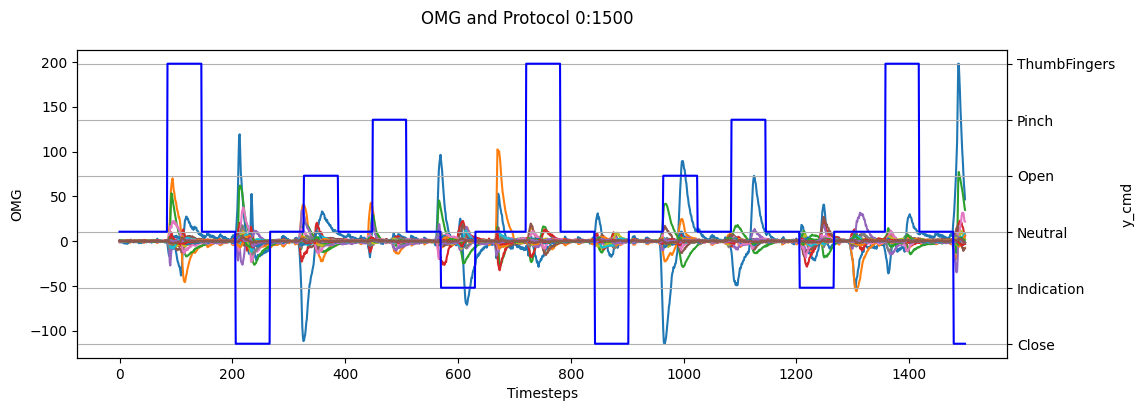

In [29]:
get_graphs(X_train_pca, y_train, start=0, end=1500)

In [30]:
samples_pca = []

for i in tqdm(range(len(samples)), desc="Processing samples"):
    train, valid = samples[i]
    pca = decomposition.PCA(n_components=0.9999, random_state=42).fit(train)
    train_pca = pca.transform(train)
    valid_pca = pca.transform(valid)
    samples_pca.append([train_pca, valid_pca])
    
samples.extend(samples_pca)

Processing samples: 100%|██████████| 12/12 [00:00<00:00, 12.51it/s]


## Экспоненциальное сглаживаение

### Сглаживание оконной функцией из scipy

In [31]:
def get_convolve(data, M=10, tau=3, sym=True):
    win = signal.windows.exponential(M, tau=tau, sym=sym)
    data_result = np.zeros((data.shape[0]))
    for i in range(data.shape[1]):
        sig = data[:, i]
        filtered = signal.convolve(sig, win, mode='same') / sum(win)
        data_result = np.column_stack((data_result, filtered))
        
    return data_result[:, 1:]

In [32]:
samples_ce = []

for i in tqdm(range(len(samples)), desc="Processing samples"):
    train, valid = samples[i]
    train_ce = get_convolve(train, M=10, tau=1, sym=False)
    valid_ce = get_convolve(valid, M=10, tau=1, sym=False)
    samples_ce.append([train_ce, valid_ce])

Processing samples: 100%|██████████| 24/24 [00:06<00:00,  3.98it/s]


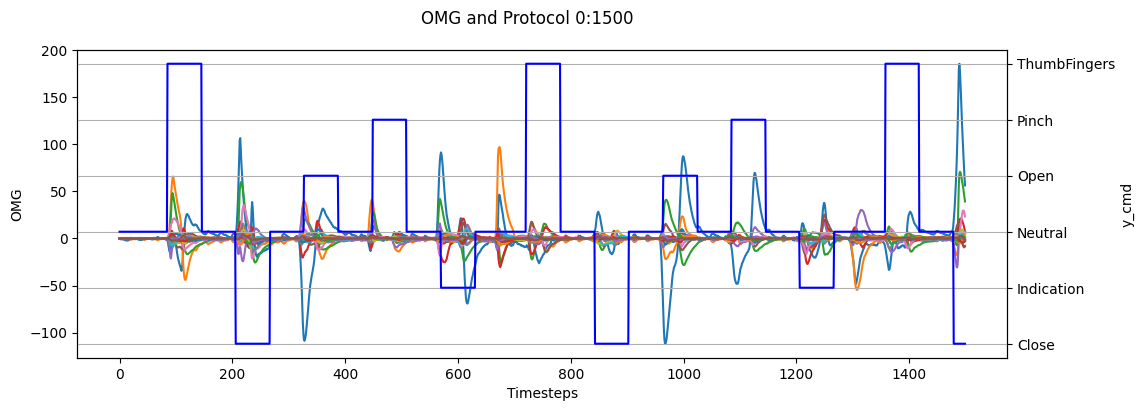

In [33]:
X_train_ce = get_convolve(X_train_pca, M=10, tau=1, sym=False)
X_valid_ce = get_convolve(X_valid_pca, M=10, tau=1, sym=False)

get_graphs(X_train_ce, y_train, start=0, end=1500)

### Сглаживание с помощью метода из pandas

In [34]:
# Функция для экспоненциального сглаживания
def get_smoothing(Xdf, sample_size=5, alpha=0.5):
    """Функция для экспоненциального сглаживания

    Args:
        Xdf (ndarray): Массив данных.
        sample_size (int, optional): Размер сглаживаемой выборки. Defaults to 5.
        alpha (float, optional): Коэффициент сглаживания. Defaults to 0.3.

    Returns:
        ndarray: Преобразованный массив.
    """
    samples, j = [], 0
    for i in range(sample_size, Xdf.shape[0] + 1, sample_size):
        x_smoothed = Xdf.loc[j:i-1, list(Xdf.columns)].ewm(alpha=alpha, adjust=True).mean().values
        samples.append(x_smoothed)
        j = i
    
    X_ewm = np.row_stack(samples)
    
    return X_ewm

In [35]:
X_train_ewm = get_smoothing(pd.DataFrame(X_train_pca), sample_size=10, alpha=0.3)
X_valid_ewm = get_smoothing(pd.DataFrame(X_valid_pca), sample_size=10, alpha=0.3)

print(X_train_pca.shape, y_train.shape)
print(X_valid_pca.shape, y_valid.shape)
print(X_train_ewm.shape, y_train.shape)
print(X_valid_ewm.shape, y_valid.shape)

(5092, 16) (5092,)
(1272, 16) (1272,)
(5090, 16) (5092,)
(1270, 16) (1272,)


In [36]:
diff1 = X_train_pca.shape[0] - X_train_ewm.shape[0]
diff2 = X_valid_pca.shape[0] - X_valid_ewm.shape[0]

zeros_array1 = np.zeros((diff1, X_train_pca.shape[1]))
zeros_array2 = np.zeros((diff2, X_valid_pca.shape[1]))

X_train_ewm = np.vstack((X_train_ewm, zeros_array1))
X_valid_ewm = np.vstack((X_valid_ewm, zeros_array2))

print(X_train_ewm.shape, y_train.shape)
print(X_valid_ewm.shape, y_valid.shape)

(5092, 16) (5092,)
(1272, 16) (1272,)


In [37]:
samples_ewm = []

for i in tqdm(range(len(samples)), desc="Processing samples"):
    train, valid = samples[i]
    train_ewm = get_smoothing(pd.DataFrame(train), sample_size=10, alpha=0.3)
    valid_ewm = get_smoothing(pd.DataFrame(valid), sample_size=10, alpha=0.3)
    diff1 = train.shape[0] - train_ewm.shape[0]
    diff2 = valid.shape[0] - valid_ewm.shape[0]
    zeros_array1 = np.zeros((diff1, train.shape[1]))
    zeros_array2 = np.zeros((diff2, valid.shape[1]))
    train_ewm = np.vstack((train_ewm, zeros_array1))
    valid_ewm = np.vstack((valid_ewm, zeros_array2))

    samples_ewm.append([train_ewm, valid_ewm])
    

samples.extend(samples_ce)
samples.extend(samples_ewm)

Processing samples: 100%|██████████| 24/24 [00:26<00:00,  1.10s/it]


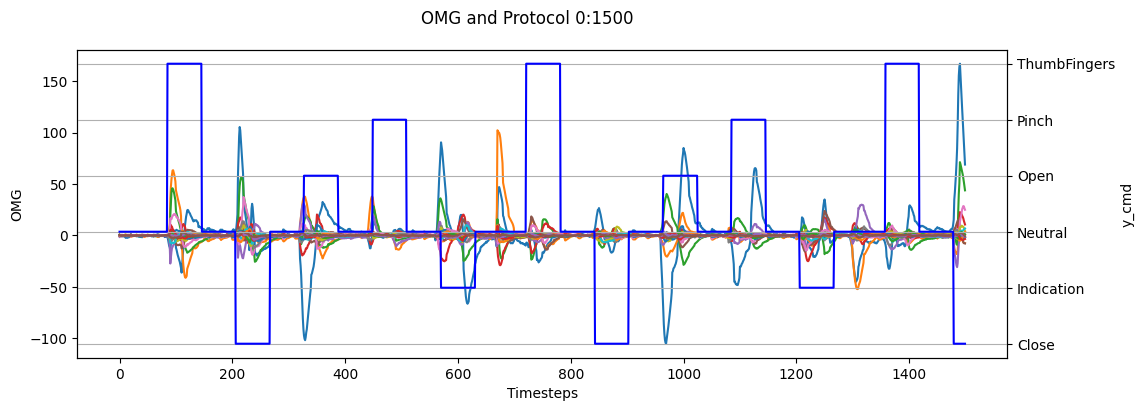

In [38]:
get_graphs(X_train_ewm, y_train, start=0, end=1500)

---
---
---

# Modeling

## Part 1.

Сперва нам нужно исследовать ряд алгоритмов с базовыми настройками "из коробки" (ну, или с некоторой минимальной настройкой гиперпараметров), чтобы определить наиболее перспективные из них — эти же в дальнешем мы будем использовать на инференсе, а также попробуем оптимизировать с помощью optuna.

Сперва соберем зоопарк алгоритмов:

In [39]:
# Наивный байесовксий классификатор
gnb = naive_bayes.GaussianNB()

# Линейная регрессия
lr = linear_model.LogisticRegression(
    solver='liblinear',
    max_iter=10000,
    random_state=42
)

# Пассивно-агрессивный классификатор
pac = linear_model.PassiveAggressiveClassifier(random_state=42)

# Простой перцептрон
pct = linear_model.Perceptron(random_state=42)

# Линейный классификатор на Тихоновской регуляризации
rc = linear_model.RidgeClassifier(random_state=42)

# Линейный классификатор на стохастическом градиентном спуске
sgdc = linear_model.SGDClassifier(random_state=42)

# Линейный классификатор на опорных векторах
lsvc = svm.LinearSVC(
    dual='auto',
    random_state=42,
    max_iter=2000
)

# Метод опорных векторов
svc = svm.SVC(random_state=42)

# Классификатор на k-ближайших соседях
knc = neighbors.KNeighborsClassifier()

# Многослойный перцептрон
mlpc = neural_network.MLPClassifier(
    max_iter=2000,
    random_state=42
)

# Дерево решений
dtc = tree.DecisionTreeClassifier(random_state=42)

# Классификатор адаптивного бустинга на деревьях решений
abc = ensemble.AdaBoostClassifier(
    estimator=tree.DecisionTreeClassifier(),
    algorithm='SAMME',
    random_state=42
)

# Простой бэггинг на деревьях решений
bc = ensemble.BaggingClassifier(
    estimator=tree.DecisionTreeClassifier(),
    n_jobs=-1,
    random_state=42
)

# Классификатор чрезвычайно рандомизированных деревьев
etc = ensemble.ExtraTreesClassifier(
    n_jobs=-1,
    random_state=42
)

# Градиентный бустинг
gbc = ensemble.GradientBoostingClassifier(random_state=42)

# Лес случайных деревьев
rfc = ensemble.RandomForestClassifier(
    n_jobs=-1,
    random_state=42
)

# Градиентный бустинг на гистограммах
hgbc = ensemble.HistGradientBoostingClassifier(random_state=42)

# Крутой градиентный бустинг :)
xgbc = xgb.XGBClassifier(seed=42, n_jobs=-1)

# Градиентный бустинг от Microsoft
lgbmc = lgbm.LGBMClassifier(
    objective='multiclass',
    seed=42
)

# Градиентный бустинг от Яндекс
cbc = cb.CatBoostClassifier(verbose=False, random_seed=42)

Итак, устроим некоторое соревнование между 20 алгоритмами.

In [40]:
# Соберем их в один список
models = [
    gnb, lr, pac, pct, rc, sgdc, lsvc, svc, knc, mlpc, 
    dtc, abc, bc, etc, gbc, rfc, hgbc, xgbc, lgbmc, cbc
]

Для каждого вида предобобработки данных прогоним весь пул алгоритмов и сохраним результат (расчет f1-weighted) в единую таблицу.

In [41]:
results = np.zeros((len(models), 0))
 
progress_bar = tqdm(samples, desc='Processing samples')
for pair in progress_bar:
    train, valid = pair
    f1_weighted = []

    for model in models:
        
        model.fit(train, y_train)
        preds_valid = model.predict(valid)
        f1_weighted.append(metrics.f1_score(y_valid, preds_valid, average='weighted'))
        
    f1_weighted_vec = np.array(f1_weighted).reshape(-1, 1)
    results = np.hstack((results, f1_weighted_vec))

Processing samples: 100%|██████████| 72/72 [2:06:12<00:00, 105.17s/it]  


Оформим получившийся массив в виде датафрейма.

In [42]:
columns = [
    'GNB', 'LR', 'PAC', 'Pct', 'RC',
    'SGDC', 'LSVC', 'SVC', 'KNC', 'MLPC',
    'DTC', 'ABC', 'BC', 'ETC', 'GBC',
    'RFC', 'HGBC', 'XGBC', 'LGBMC', 'CBC'
]

results_df = pd.DataFrame(data=results.T, columns=columns)

# Сохранение датафрейма в CSV файл
results_df.to_csv(f'{palm_file.split("/")[-1].split(".")[0]}_extended_results.csv', index=False)

Составим схему для расшифровки значений индексов, чтобы определить тип предобработки.

|idx|definition|idx|definition|
|-|-|-|-|
|`0`|исходные данные|`6`|`0` + кэфф-ы лин. рег. из `0`|
|`1`|стандартизированные данные|`7`|`1` + кэфф-ы лин. рег. из `1`|
|`2`|кэфф-ы авт-рег. из `0`|`8`|`0` + `2`|
|`3`|кэфф-ы авт-рег. из `1`|`9`|`1` + `3`|
|`4`|`2` + кэфф-ы лин. рег. из `0`|`10`|`0` + `2` + кэфф-ы лин. рег. из `0`|
|`5`|`3` + кэфф-ы лин. рег. из `1`|`11`|`1` + `3` + кэфф-ы лин. рег. из `1`|


- Индексы `12-23` соответствуют тем же комбинациям + понижение размерности на PCA.
- Индексы `24-47` соответствуют тем же комбинациям (24-35: без PCA; 36-47 c PCA) + сглаживание CE.
- Индексы `48-71` соответствуют тем же комбинациям (48-59: без PCA; 60-71 c PCA) + сглаживание EWM.

In [44]:
pd.set_option('display.max_rows', None)

# Если требуется подгрузить таблицу полученных ранее результатов 
results_df = pd.read_csv('2024-03-04_10-00-21_extended_results.csv')

display(results_df.style.background_gradient(
    cmap='coolwarm',
    vmin=results_df.min().min(), vmax=results_df.max().max(),
    subset=list(results_df.columns)
))

# Составим топ алгоритмов
i = 10
top_values = results_df.stack().nlargest(i)  # Получаем топ-i наибольших значений в датафрейме
for index, value in top_values.items():  # Перебираем полученные значения и их индексы
    row, col = index  # Получаем индекс строки и столбца
    print(f"Индекс: {row}".ljust(10), f"| Алгоритм: {col}".ljust(17), f"| Метрика: {round(value, 4)}")

,GNB,LR,PAC,Pct,RC,SGDC,LSVC,SVC,KNC,MLPC,DTC,ABC,BC,ETC,GBC,RFC,HGBC,XGBC,LGBMC,CBC
0,0.201802,0.440160,0.432967,0.468042,0.425170,0.445686,0.427680,0.744045,0.824442,0.802057,0.741683,0.779901,0.801885,0.831870,0.803275,0.832591,0.822971,0.812362,0.823793,0.828310
1,0.133678,0.437256,0.453315,0.446792,0.426413,0.490330,0.428901,0.754236,0.810349,0.814238,0.747486,0.780180,0.802751,0.831870,0.804065,0.832689,0.822971,0.812362,0.819811,0.828310
2,0.333845,0.538849,0.473728,0.510553,0.490255,0.520941,0.518005,0.721942,0.706368,0.730015,0.643907,0.659503,0.744679,0.768050,0.815653,0.779417,0.812570,0.825063,0.816088,0.821458
3,0.333935,0.704368,0.672693,0.662847,0.668162,0.687199,0.715961,0.784822,0.808406,0.811055,0.701472,0.713190,0.788045,0.820630,0.829133,0.825699,0.835635,0.845830,0.835271,0.838826
4,0.357153,0.549712,0.477413,0.508731,0.502269,0.494081,0.537669,0.696723,0.677680,0.712010,0.652257,0.655712,0.740907,0.765127,0.812085,0.773288,0.820700,0.827568,0.812491,0.819126
5,0.179510,0.699031,0.660999,0.650912,0.670856,0.703951,0.719546,0.734284,0.736003,0.807673,0.704473,0.702935,0.787237,0.823346,0.826810,0.822724,0.848271,0.850730,0.846880,0.839886
6,0.229579,0.455789,0.434233,0.498100,0.439378,0.451870,0.448352,0.747897,0.828833,0.799242,0.750387,0.744599,0.805461,0.830866,0.815127,0.833618,0.828612,0.818371,0.823752,0.822301
7,0.159852,0.456314,0.474646,0.465665,0.429377,0.519444,0.447391,0.733201,0.787542,0.790768,0.728692,0.739198,0.815400,0.835512,0.816155,0.830989,0.821668,0.827037,0.826139,0.818807
8,0.439603,0.595364,0.417569,0.543324,0.551512,0.574895,0.593919,0.744656,0.832531,0.831534,0.685327,0.686941,0.757230,0.804447,0.826229,0.804187,0.818007,0.834067,0.817530,0.828683
9,0.080141,0.713041,0.610212,0.596362,0.700841,0.676732,0.720546,0.766994,0.814348,0.807314,0.732375,0.726961,0.795518,0.826750,0.842530,0.834761,0.834864,0.842547,0.845928,0.837066


Индекс: 32 | Алгоритм: CBC   | Метрика: 0.8639
Индекс: 34 | Алгоритм: LGBMC | Метрика: 0.8599
Индекс: 29 | Алгоритм: CBC   | Метрика: 0.8585
Индекс: 26 | Алгоритм: CBC   | Метрика: 0.8562
Индекс: 48 | Алгоритм: ETC   | Метрика: 0.8548
Индекс: 59 | Алгоритм: XGBC  | Метрика: 0.8545
Индекс: 33 | Алгоритм: CBC   | Метрика: 0.8536
Индекс: 49 | Алгоритм: ETC   | Метрика: 0.8531
Индекс: 34 | Алгоритм: HGBC  | Метрика: 0.8528
Индекс: 57 | Алгоритм: XGBC  | Метрика: 0.8526


Далее можно пробовать оптимизировать эти алгоритмы с соответствующими наборами данных.

---
## Part 2.

Здесь проводятся отдельные испытания алгоритмов, а также их оптимизация.

---
### GaussianNB

#### Baseline

In [41]:
model = naive_bayes.GaussianNB()

# train_--, valid_-- = samples[--]

# model.fit(train_--, y_train)
# model.score(train_--, y_train)

0.6757659073055774

In [93]:
model = naive_bayes.GaussianNB()

model.fit(encoded_train, y_train)
model.score(encoded_train, y_train)

0.8758974358974358

#### Optimized

In [38]:
# # Определение функции для оптимизации
# def optuna_gnb(trial):
#     """Функция, обучающая модель GaussianNB по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     var_smoothing = trial.suggest_float('var_smoothing', 1e-10, 1e-1)
    
#     # Инициализация GaussianNB с оптимизируемыми гиперпараметрами
#     clf = naive_bayes.GaussianNB(
#         var_smoothing=var_smoothing
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=10, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_gnb = optuna.create_study(study_name="gnb_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=1000, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_gnb.optimize(optuna_gnb, n_trials=1000, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_gnb.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = naive_bayes.GaussianNB(**study_gnb.best_params)
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [39]:
# Сохранение модели
# joblib.dump(model, "models/-_--_opt_gnb.pkl")

---
### LogisticRegression

#### Baseline

In [47]:
model = linear_model.LogisticRegression(
    solver='liblinear',
    max_iter=10000,
    random_state=42
)

# train_-, valid_- = samples[-]

# model.fit(train_-, y_train)
# model.score(train_-, y_train)

0.5624509033778476

#### Optimized

In [41]:
# # Определение функции для оптимизации
# def optuna_lr(trial):
#     """Функция, обучающая модель LogisticRegression по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     C = trial.suggest_float('C', 1e-5, 1e2)
#     penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    
#     if penalty == 'elasticnet':
#         l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
#     else:
#         l1_ratio = None

#     solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'saga'])

#     if penalty == 'l1' and solver in ['newton-cg', 'lbfgs', 'sag']:
#         return 0.0 # 'l1' penalty is not supported by these solvers
#     elif penalty == 'elasticnet' and solver not in ['saga']:
#         return 0.0 # 'elasticnet' penalty is supported only by 'saga' solver
    
#     # Инициализация LogisticRegression с оптимизируемыми гиперпараметрами
#     clf = linear_model.LogisticRegression(
#         C=C, penalty=penalty, solver=solver,
#         l1_ratio=l1_ratio, max_iter=10000,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_lr = optuna.create_study(study_name="lr_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=50, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_lr.optimize(optuna_lr, n_trials=50, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_lr.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = linear_model.LogisticRegression(
#     **study_lr.best_params,
#     max_iter=10000,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [42]:
# Сохранение модели
# joblib.dump(model, "models/-_--_opt_lr.pkl")

---
### PassiveAggressiveClassifier

#### Baseline

In [43]:
model = linear_model.PassiveAggressiveClassifier(random_state=42)

# train_--, valid_-- = samples[--]

# model.fit(train_--, y_train)
# model.score(train_--, y_train)

0.5373134328358209

#### Optimized

In [44]:
# # Определение функции для оптимизации
# def optuna_pac(trial):
#     """Функция, обучающая модель PassiveAggressive по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'C': trial.suggest_float('C', 1e-5, 1e5),
#         'max_iter': trial.suggest_int('max_iter', 100, 3000),
#         'early_stopping': True,
#         'n_jobs': -1
#     }

#     # Инициализация PassiveAggressive с оптимизируемыми гиперпараметрами
#     clf = linear_model.PassiveAggressiveClassifier(
#         **params,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_pac = optuna.create_study(study_name="pac_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=1000, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_pac.optimize(optuna_pac, n_trials=1000, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_pac.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = linear_model.PassiveAggressiveClassifier(
#     **study_pac.best_params,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [45]:
# Сохранение модели
# joblib.dump(model, "models/-_--_opt_pac.pkl")

---
### Perceptron

#### Baseline

In [44]:
model = linear_model.Perceptron(random_state=42)

# train_--, valid_-- = samples[--]

# model.fit(train_--, y_train)
# model.score(train_--, y_train)

0.5883739198743126

#### Optimized

In [47]:
# # Определение функции для оптимизации
# def optuna_pct(trial):
#     """Функция, обучающая модель Perceptron по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'penalty': trial.suggest_categorical('penalty', [None, 'l2', 'l1', 'elasticnet']),
#         'alpha': trial.suggest_float('alpha', 1e-5, 1e5),
#         'l1_ratio': trial.suggest_float('l1_ratio', 1e-5, 1),
#         'max_iter': trial.suggest_int('max_iter', 100, 3000),
#         'early_stopping': True,
#         'n_jobs': -1
#     }

#     # Инициализация Perceptron с оптимизируемыми гиперпараметрами
#     clf = linear_model.Perceptron(
#         **params,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=10, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_pct = optuna.create_study(study_name="pct_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=2000, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_pct.optimize(optuna_pct, n_trials=2000, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_pct.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = linear_model.Perceptron(
#     **study_pct.best_params,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [48]:
# Сохранение модели
# joblib.dump(model, "models/-_--_opt_pct.pkl")

---
### RidgeClassifier

#### Baseline

In [45]:
model = linear_model.RidgeClassifier(random_state=42)

# train_--, valid_-- = samples[--]

# model.fit(train_--, y_train)
# model.score(train_--, y_train)

0.5701099764336214

#### Optimized

In [50]:
# # Определение функции для оптимизации
# def optuna_rdg(trial):
#     """Функция, обучающая модель Ridge по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'alpha': trial.suggest_float('alpha', 1e-5, 1e-1),
#         'solver': trial.suggest_categorical('solver',
#             ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
#     }
    
#     # Инициализация Ridge с оптимизируемыми гиперпараметрами
#     clf = linear_model.RidgeClassifier(
#         **params,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=10, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_rdg = optuna.create_study(study_name="rdg_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=300, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_rdg.optimize(optuna_rdg, n_trials=300, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_rdg.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = linear_model.RidgeClassifier(
#     **study_rdg.best_params,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [51]:
# Сохранение модели
# joblib.dump(model, "models/-_--_opt_rdg.pkl")

---
### SGDClassifier

#### Baseline

In [46]:
model = linear_model.SGDClassifier(random_state=42)

# train_--, valid_-- = samples[--]

# model.fit(train_--, y_train)
# model.score(train_--, y_train)

0.5767871170463472

#### Optimized

In [53]:
# # Определение функции для оптимизации
# def optuna_sgdc(trial):
#     """Функция, обучающая модель SGD по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'loss': trial.suggest_categorical('loss',
#             ['hinge', 'log_loss', 'huber', 'modified_huber', 'squared_hinge', 'perceptron']),
#         'penalty': trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet']),
#         'alpha': trial.suggest_float('alpha', 1e-5, 1e-1),
#         'l1_ratio': trial.suggest_float('l1_ratio', 1e-5, 1),
#         'max_iter': trial.suggest_int('max_iter', 100, 1000),
#         'n_jobs': -1,
#         'early_stopping': True,
#     }
    
#     # Инициализация SGD с оптимизируемыми гиперпараметрами
#     clf = linear_model.SGDClassifier(
#         **params,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=10, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_sgdc = optuna.create_study(study_name="sgdc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=500, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_sgdc.optimize(optuna_sgdc, n_trials=500, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_sgdc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = linear_model.SGDClassifier(
#     **study_sgdc.best_params,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [54]:
# Сохранение модели
# joblib.dump(model, "models/-_--_opt_sgdc.pkl")

---
### LinearSVC

#### Baseline

In [47]:
model = svm.LinearSVC(
    dual='auto',
    random_state=42,
    max_iter=2000
)

# train_--, valid_-- = samples[--]

# model.fit(train_--, y_train)
# model.score(train_--, y_train)

0.5761979575805185

#### Optimized

In [56]:
# # Определение функции для оптимизации
# def optuna_lsvc(trial):
#     """Функция, обучающая модель LinearSVC по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     penalty = trial.suggest_categorical('penalty', ['l2', 'l1'])
#     C = trial.suggest_float('C', 1e-5, 1e2)
#     multi_class = trial.suggest_categorical('multi_class', ['ovr', 'crammer_singer'])
    
#     if penalty == 'l1':
#         loss = 'squared_hinge'
#     else:
#         loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])

#     clf = svm.LinearSVC(
#         penalty=penalty, loss=loss, dual='auto',
#         C=C, multi_class=multi_class,
#         random_state=42, max_iter=10000
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_lsvc = optuna.create_study(study_name="lsvc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=100, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_lsvc.optimize(optuna_lsvc, n_trials=100, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_lsvc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = svm.LinearSVC(
#     **study_lsvc.best_params,
#     dual='auto',
#     random_state=42,
#     max_iter=10000
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [57]:
# Сохранение модели
# joblib.dump(model, "models/-_--_opt_lsvc.pkl")

---
### SVC

#### Baseline

In [48]:
model = svm.SVC(random_state=42)

# train_--, valid_-- = samples[--]

# model.fit(train_--, y_train)
# model.score(train_--, y_train)

0.8505498821681068

#### Optimized

In [59]:
# # Определение функции для оптимизации
# def optuna_svc(trial):
#     """Функция, обучающая модель SVC по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'C': trial.suggest_float('C', 1e-5, 1e2),
#         'degree': trial.suggest_int('degree', 0, 20)
#     }

#     clf = svm.SVC(
#         **params,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_svc = optuna.create_study(study_name="svc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=50, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_svc.optimize(optuna_svc, n_trials=50, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_svc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = svm.SVC(
#     **study_svc.best_params,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [60]:
# Сохранение модели
# joblib.dump(model, "models/-_--_opt_svc.pkl")

---
### KNeighborsClassifier

#### Baseline

In [49]:
model = neighbors.KNeighborsClassifier()

# train_--, valid_-- = samples[--]

# model.fit(train_--, y_train)
# model.score(train_--, y_train)

0.9662215239591516

#### Optimized

In [62]:
# # Напишем функцию для оптимизации
# def optuna_knc(trial):
#     """Функция, обучающая модель KNeighborsClassifier по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'n_neighbors': trial.suggest_int('n_neighbors', 1, 30),
#         'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
#         'p': trial.suggest_int('p', 1, 2),
#         'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
#         'leaf_size': trial.suggest_int('leaf_size', 10, 50)
#     }

#     clf = neighbors.KNeighborsClassifier(**params)
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=10, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_knc = optuna.create_study(study_name="knc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=200, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_knc.optimize(optuna_knc, n_trials=200, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_knc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = neighbors.KNeighborsClassifier(**study_knc.best_params)
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [63]:
# Сохранение модели
# joblib.dump(model, "models/-_--_opt_knc.pkl")

---
### MLPClassifier

#### Baseline

In [50]:
model = neural_network.MLPClassifier(
    max_iter=2000,
    random_state=42
)

# train_--, valid_-- = samples[--]

# model.fit(train_--, y_train)
# model.score(train_--, y_train)

0.9850746268656716

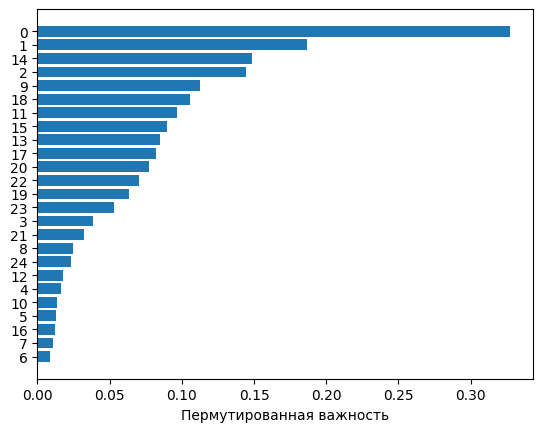

In [348]:
# Оценка значимости признаков
result = inspection.permutation_importance(
    model, X_train_ce, y_train, n_repeats=10, random_state=42
)
# Визуализация значимости признаков
sorted_idx = np.argsort(result.importances_mean)
plt.barh(range(X_train_ce.shape[1]), result.importances_mean[sorted_idx], align='center')
plt.yticks(range(X_train_ce.shape[1]), np.array(pd.DataFrame(X_train_ce).columns)[sorted_idx])
plt.xlabel('Пермутированная важность')
plt.show()

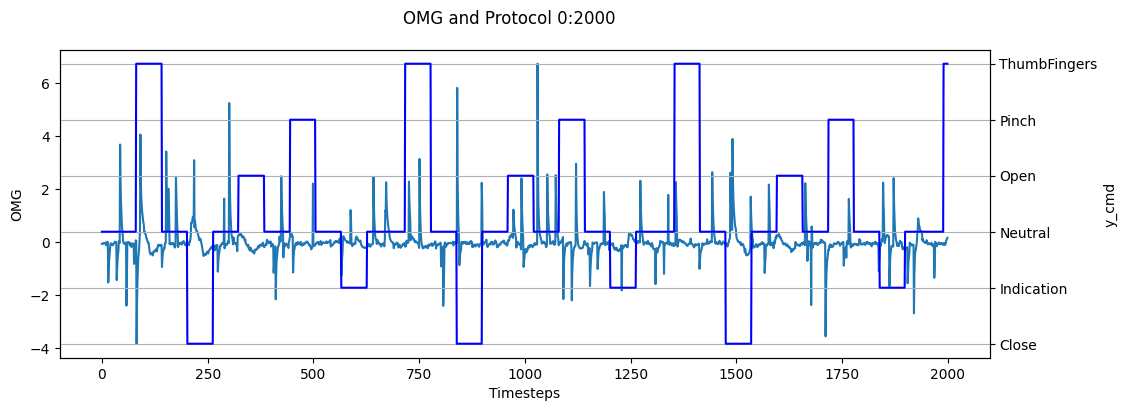

In [351]:
get_graphs(X_train_ewm[:, 6], y_train, start=0, end=2000)

#### Optimized

In [65]:
# # Напишем функцию для оптимизации
# def optuna_mlp(trial):
#     """Функция, обучающая модель MLPClassifier по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'activation': trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu']),
#         'alpha': trial.suggest_float('alpha', 1e-5, 1e-2),
#         'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'adaptive'])
#     }
    
#     if trial.suggest_categorical('use_second_hidden_layer', [True, False]):
#         params['hidden_layer_sizes'] = (trial.suggest_int('n_units1', 1, 200),
#                                          trial.suggest_int('n_units2', 1, 200))
#     else:
#         params['hidden_layer_sizes'] = (trial.suggest_int('n_units1', 1, 200),)
    
#     # Инициализация MLPClassifier с оптимизируемыми гиперпараметрами
#     clf = neural_network.MLPClassifier(
#         **params,
#         max_iter=3000,
#         random_state=42
#     )

#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=10, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_mlp = optuna.create_study(study_name="mlp_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=50, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_mlp.optimize(optuna_mlp, n_trials=50, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_mlp.best_params)

# best_params = study_mlp.best_params
# n_units1 = best_params.pop('n_units1')
# flag = best_params.pop('use_second_hidden_layer')
# if flag:
#     n_units2 = best_params.pop('n_units2')
#     hidden_layer_sizes = (n_units1, n_units2)
# else:
#     hidden_layer_sizes = (n_units1,)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = neural_network.MLPClassifier(
#     hidden_layer_sizes=hidden_layer_sizes,
#     **best_params,
#     max_iter=3000,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [66]:
# Сохранение модели
# joblib.dump(model, "models/-_--_opt_mlp.pkl")

---
### DecisionTreeClassifier

#### Baseline

In [51]:
model = tree.DecisionTreeClassifier(random_state=42)

# train_--, valid_-- = samples[--]

# model.fit(train_--, y_train)
# model.score(train_--, y_train)

1.0

#### Optimized

In [68]:
# # Напишем функцию для оптимизации
# def optuna_dtc(trial):
#     """Функция, обучающая модель DecisionTreeClassifier по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
#         'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
#         'max_depth': trial.suggest_int('max_depth', 2, 32),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
#     }
#     # Инициализация DecisionTreeClassifier с оптимизируемыми гиперпараметрами
#     clf = tree.DecisionTreeClassifier(
#         **params, random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=10, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_dtc = optuna.create_study(study_name="dtc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=200, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_dtc.optimize(optuna_dtc, n_trials=200, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_dtc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = tree.DecisionTreeClassifier(
#     **study_dtc.best_params,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [69]:
# Сохранение модели
# joblib.dump(model, "models/-_--_opt_dtc.pkl")

---
### AdaBoostClassifier

#### Baseline

In [52]:
model = ensemble.AdaBoostClassifier(
    estimator=tree.DecisionTreeClassifier(),
    algorithm='SAMME',
    random_state=42
)

# train_--, valid_-- = samples[--]

# model.fit(train_--, y_train)
# model.score(train_--, y_train)

1.0

#### Optimized

In [71]:
# # Напишем функцию для оптимизации
# def optuna_abc(trial):
#     """Функция, обучающая модель AdaBoostClassifier по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     n_estimators = trial.suggest_int('n_estimators', 50, 200)
#     learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0)
    
#     estimator = tree.DecisionTreeClassifier(
#         max_depth=trial.suggest_int('max_depth', 1, 18),
#         criterion=trial.suggest_categorical('criterion', ['gini', 'entropy']),
#         splitter=trial.suggest_categorical('splitter', ['best', 'random']),
#         min_samples_split=trial.suggest_int('min_samples_split', 2, 12),
#         min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 12)
#     )
#     # Инициализация AdaBoost с оптимизируемыми гиперпараметрами
#     clf = ensemble.AdaBoostClassifier(
#         estimator=estimator,
#         n_estimators=n_estimators,
#         learning_rate=learning_rate,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_abc = optuna.create_study(study_name="abc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=50, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_abc.optimize(optuna_abc, n_trials=50, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_abc.best_params)
# best_params = study_abc.best_params
# n_estimators = best_params.pop('n_estimators')
# learning_rate = best_params.pop('learning_rate')

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = ensemble.AdaBoostClassifier(
#     estimator=tree.DecisionTreeClassifier(**best_params),
#     n_estimators=n_estimators,
#     learning_rate=learning_rate,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [72]:
# Сохранение модели
# joblib.dump(model, "models/-_--_opt_abc.pkl")

---
### BaggingClassifier

#### Baseline

In [53]:
model = ensemble.BaggingClassifier(
    estimator=tree.DecisionTreeClassifier(),
    n_jobs=-1,
    random_state=42
)

# train_--, valid_-- = samples[--]

# model.fit(train_--, y_train)
# model.score(train_--, y_train)

0.9978397486252946

#### Optimized

In [74]:
# # Напишем функцию для оптимизации
# def optuna_bc(trial):
#     """Функция, обучающая модель BaggingClassifier по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     n_estimators = trial.suggest_int('n_estimators', 10, 200)
#     max_samples = trial.suggest_float('max_samples', 0.1, 1.0)
#     max_features = trial.suggest_float('max_features', 0.1, 1.0)
    
#     # estimator = tree.DecisionTreeClassifier(
#     #     max_depth=trial.suggest_int('max_depth', 1, 18),
#     #     criterion=trial.suggest_categorical('criterion', ['gini', 'entropy']),
#     #     splitter=trial.suggest_categorical('splitter', ['best', 'random']),
#     #     min_samples_split=trial.suggest_int('min_samples_split', 2, 12),
#     #     min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 12)
#     # )
#     # Инициализация BaggingClassifier с оптимизируемыми гиперпараметрами
#     clf = ensemble.BaggingClassifier(
#         # estimator=estimator,
#         n_estimators=n_estimators,
#         max_samples=max_samples,
#         max_features=max_features,
#         n_jobs=-1,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_bc = optuna.create_study(study_name="bc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=100, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_bc.optimize(optuna_bc, n_trials=100, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_bc.best_params)
# # best_params = study_bc.best_params
# # n_estimators = best_params.pop('n_estimators')
# # learning_rate = best_params.pop('learning_rate')

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = ensemble.BaggingClassifier(
#     # estimator=tree.DecisionTreeClassifier(**best_params),
#     **study_bc.best_params,
#     n_jobs=-1,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [75]:
# Сохранение модели
# joblib.dump(model, "models/-_--_opt_bc.pkl")

---
### ExtraTreesClassifier

#### Baseline

In [63]:
model = ensemble.ExtraTreesClassifier(
    n_jobs=-1,
    random_state=42
)

train_53, valid_53 = samples[53]

model.fit(train_53, y_train)
model.score(train_53, y_train)

1.0

In [131]:
model = ensemble.ExtraTreesClassifier(
    n_jobs=-1,
    random_state=42
)

model.fit(encoded_train, y_train)
model.score(encoded_train, y_train)

1.0

In [63]:
model = ensemble.ExtraTreesClassifier(
    n_jobs=-1,
    random_state=42
)

model.fit(X_train, y_train)
model.score(X_train, y_train)

1.0

#### Optimized

In [77]:
# # Напишем функцию для оптимизации
# def optuna_etc(trial):
#     """Функция, обучающая модель ExtraTreesClassifier по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
#     }
    
#     # Инициализация ExtraTrees с оптимизируемыми гиперпараметрами
#     clf = ensemble.ExtraTreesClassifier(
#         **params,
#         n_jobs=-1,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=10, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_etc = optuna.create_study(study_name="etc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=100, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_etc.optimize(optuna_etc, n_trials=100, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_etc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = ensemble.ExtraTreesClassifier(
#     **study_etc.best_params,
#     n_jobs=-1,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [78]:
# Сохранение модели
# joblib.dump(model, "models/-_--_opt_etc.pkl")

---
### GradientBoostingClassifier

#### Baseline

In [40]:
%%time
model = ensemble.GradientBoostingClassifier(random_state=42)

# train_56, valid_56 = samples[56]

# model.fit(train_56, y_train)
# model.score(train_56, y_train)

train_28, valid_28 = samples[28]

model.fit(train_28, y_train)
model.score(train_28, y_train)

CPU times: total: 1min 2s
Wall time: 1min 2s


1.0

#### Optimized

In [80]:
# # Напишем функцию для оптимизации
# def optuna_gbc(trial):
#     """Функция, обучающая модель GradientBoosting по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
#         'max_depth': trial.suggest_int('max_depth', 3, 10)
#     }
    
#     # Инициализация GradientBoosting с оптимизируемыми гиперпараметрами
#     clf = ensemble.GradientBoostingClassifier(
#         **params,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_gbc = optuna.create_study(study_name="gbc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=50, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_gbc.optimize(optuna_gbc, n_trials=50, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_gbc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = ensemble.GradientBoostingClassifier(
#     **study_gbc.best_params,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [81]:
# Сохранение модели
# joblib.dump(model, "models/-_--_opt_gbc.pkl")

---
### RandomForestClassifier

#### Baseline

In [44]:
model = ensemble.RandomForestClassifier(
    n_jobs=-1,
    random_state=42
)

train_10, valid_10 = samples[10]

model.fit(train_10, y_train)
model.score(train_10, y_train)

1.0

#### Optimized

In [100]:
# Напишем функцию для оптимизации
def optuna_rfc(trial):
    """Функция, обучающая модель RandomForest по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика F1-weighted
    """
    # Задаем пространство поиска гиперпараметров
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 3, 45),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }
    
    # Инициализация RandomForest с оптимизируемыми гиперпараметрами
    clf = ensemble.RandomForestClassifier(
        **params,
        n_jobs=-1,
        random_state=42
    )
    # Рассчитываем метрику на кросс-валидации
    score = model_selection.cross_val_score(
        clf, train_10, y_train, cv=5, scoring="f1_weighted", n_jobs=-1
    ).mean()
    
    return score


# Создаем объект исследования для первого набора гиперпараметров
# Укажем, что нам необходимо максимизировать метрику direction="maximize"
study_rfc = optuna.create_study(study_name="rfc_opt", direction='maximize')
# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Мониторим прогресс оптимизации
with tqdm(total=50, desc="Optimizing") as pbar:
    def update(study, trial):
        pbar.update()
    # Ищем лучшую комбинацию гиперпараметров n_trials раз
    study_rfc.optimize(optuna_rfc, n_trials=50, callbacks=[update])

# Получение оптимальных гиперпараметров
print("Лучшие гиперпараметры:", study_rfc.best_params)

# Передаем модели коллекцию оптимальных гиперпараметров
model = ensemble.RandomForestClassifier(
    **study_rfc.best_params,
    n_jobs=-1,
    random_state=42
)
# Обучение
model.fit(train_10, y_train)
model.score(train_10, y_train)

[I 2024-03-19 21:05:34,757] A new study created in memory with name: rfc_opt
Optimizing: 100%|██████████| 50/50 [01:58<00:00,  2.38s/it]


Лучшие гиперпараметры: {'n_estimators': 256, 'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 2}


0.9982325216025137

In [101]:
# Сохранение модели
# joblib.dump(model, "models/0_10_opt_rfc.pkl")

['models/0_10_opt_rfc.pkl']

---
### HistGradientBoostingClassifier

#### Baseline

In [57]:
model = ensemble.HistGradientBoostingClassifier(random_state=42)

# train_--, valid_-- = samples[--]

# model.fit(train_--, y_train)
# model.score(train_--, y_train)

1.0

#### Optimized

In [86]:
# # Напишем функцию для оптимизации
# def optuna_hgbc(trial):
#     """Функция, обучающая модель HistGradientBoosting по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
#         'max_iter': trial.suggest_int('max_iter', 10, 300),
#         'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 50),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 30),
#         'l2_regularization': trial.suggest_float('l2_regularization', 0, 100) 
#     }
    
#     # Инициализация HistGradientBoosting с оптимизируемыми гиперпараметрами
#     clf = ensemble.HistGradientBoostingClassifier(
#         **params,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_hgbc = optuna.create_study(study_name="hgbc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=100, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_hgbc.optimize(optuna_hgbc, n_trials=100, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_hgbc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = ensemble.HistGradientBoostingClassifier(
#     **study_hgbc.best_params,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [87]:
# Сохранение модели
# joblib.dump(model, "models/-_--_opt_hgbc.pkl")

---
### XGBClassifier

#### Baseline

In [57]:
model = xgb.XGBClassifier(seed=42, n_jobs=-1)

train_33, valid_33 = samples[28]

model.fit(train_33, y_train)
model.score(train_33, y_train)

1.0

#### Optimized

In [89]:
# # Напишем функцию для оптимизации
# def optuna_xgbc(trial):
#     """Функция, обучающая модель XGB по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     param = {
#         'objective': 'multi:softmax',
#         'num_class': 6,
#         'eval_metric': 'mlogloss',
#         'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
#         'verbosity': 0,
#         'subsample': 0.5,
#         'learning_rate': trial.suggest_float('learning_rate', 0, 0.3),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'alpha': trial.suggest_float('alpha', 0.01, 50.0, log=True),
#         'lambda': trial.suggest_float('lambda', 0.01, 50.0, log=True),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
#         'gamma': trial.suggest_float('gamma', 0, 50)
#     }
    
#     # Инициализация XGB с оптимизируемыми гиперпараметрами
#     clf = xgb.XGBClassifier(**param, random_state=42, n_jobs=-1)
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_xgbc = optuna.create_study(study_name="xgbc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=10, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_xgbc.optimize(optuna_xgbc, n_trials=10, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_xgbc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = xgb.XGBClassifier(
#     **study_xgbc.best_params,
#     random_state=42, n_jobs=-1
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [90]:
# Сохранение модели
# joblib.dump(model, "models/-_--_opt_xgbc.pkl")

---
### LGBMClassifier

#### Baseline

In [44]:
%%time
model = lgbm.LGBMClassifier(
    objective='multiclass',
    seed=42
)

train_36, valid_36 = samples[36]

model.fit(train_36, y_train)
model.score(train_36, y_train)

CPU times: total: 4.61 s
Wall time: 422 ms


1.0

#### Optimized

In [91]:
# # Напишем функцию для оптимизации
# def optuna_lgbm(trial):
#     """Функция, обучающая модель LGBM по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'objective': 'multiclass',
#         'metric': 'softmax',
#         'verbosity': -1,
#         'boosting_type': 'gbdt',
#         'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
#         'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#     }

#     clf = lgbm.LGBMClassifier(**params, seed=42)
    
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ewm, y_train, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_lgbm = optuna.create_study(study_name="lgbm_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=100, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_lgbm.optimize(optuna_lgbm, n_trials=100, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_lgbm.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = lgbm.LGBMClassifier(
#     **study_lgbm.best_params,
#     seed=42
# )
# # Обучение
# # model.fit(X_train_ce, y_train)
# # model.score(X_train_ce, y_train)

# model.fit(X_train_ewm, y_train)
# model.score(X_train_ewm, y_train)

In [ ]:
# Сохранение модели
# joblib.dump(model, "models/-_--_opt_lgbm.pkl")

---
### CatBoostClassifier

#### Baseline

In [45]:
model = cb.CatBoostClassifier(verbose=False, random_seed=42)

train_32, valid_32 = samples[32]

model.fit(train_32, y_train)
model.score(train_32, y_train)

1.0

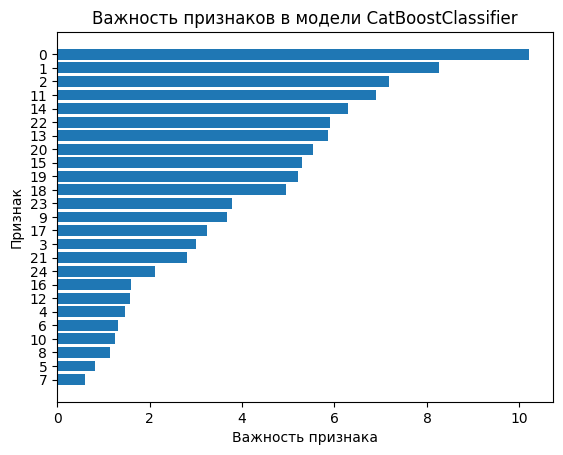

In [320]:
# Важность признаков
feature_importance = model.feature_importances_
# Сортировка важности признаков и вывод результатов
sorted_idx = np.argsort(feature_importance)
# Визуализация важности признаков
plt.barh(range(len(feature_importance)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(feature_importance)), np.array(pd.DataFrame(X_train_ce).columns)[sorted_idx])
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в модели CatBoostClassifier')
plt.show()

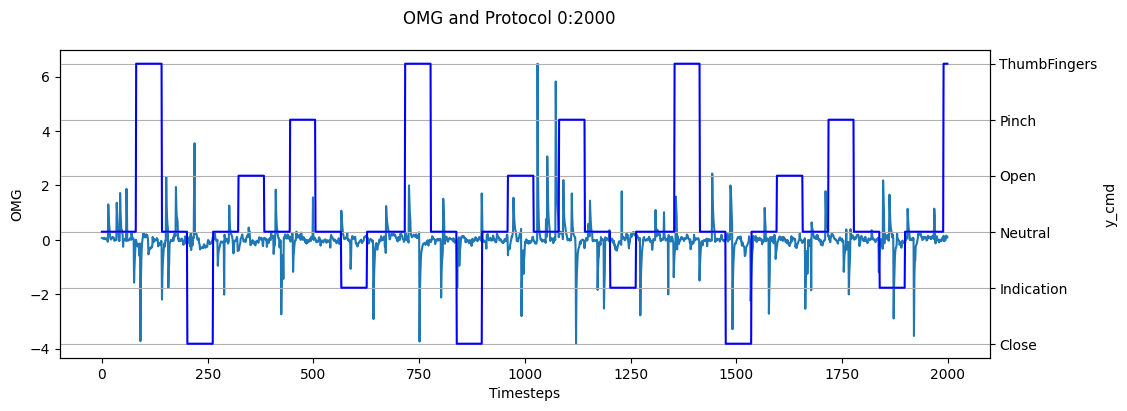

In [324]:
get_graphs(X_train_ewm[:, 7], y_train, start=0, end=2000)

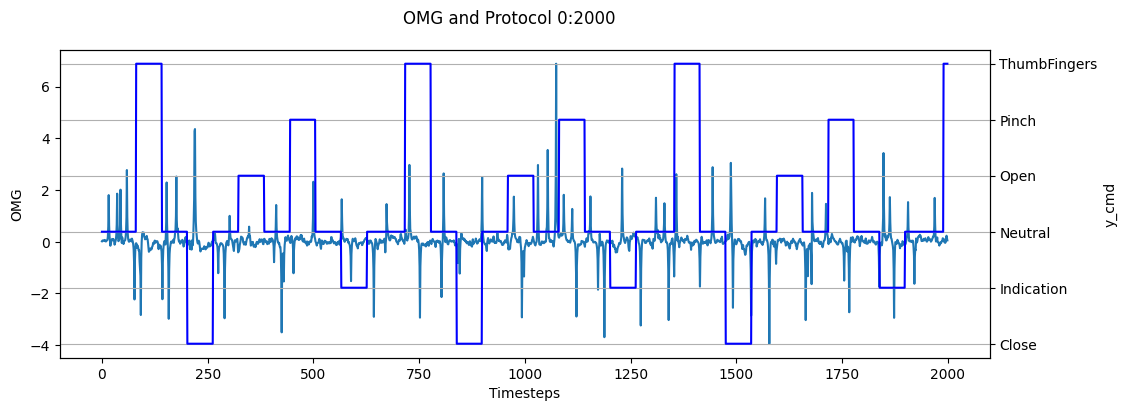

In [318]:
get_graphs(X_train_ce[:, 7], y_train, start=0, end=2000)

#### Optimized

In [92]:
# # Напишем функцию для оптимизации
# def optuna_cbc(trial):
#     """Функция, обучающая модель CatBoost по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     # params = {
#     #     'depth': trial.suggest_int('depth', 4, 10),
#     #     'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#     #     'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
#     #     'random_strength': trial.suggest_float('random_strength', 1, 15),
#     #     'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 15),
#     # }
    
#     params = {
#         # "objective": "MultiClass",
#         # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 15),
#         "depth": trial.suggest_int("depth", 1, 12),
#         # "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#         # "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
#         # "used_ram_limit": "3gb",
#     }

#     # if params["bootstrap_type"] == "Bayesian":
#     #     params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
#     # elif params["bootstrap_type"] == "Bernoulli":
#     #     params["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    
#     clf = cb.CatBoostClassifier(**params, verbose=False, random_seed=42)

#     # pruning_callback = CatBoostPruningCallback(trial, "MultiClass")
#     # clf.fit(
#     #     X_train_ce,
#     #     y_train,
#     #     verbose=0,
#         # eval_set=[(X_valid_ce, y_valid)],
#         # early_stopping_rounds=100,
#         # callbacks=[pruning_callback],
#     # )

#     # # evoke pruning manually.
#     # pruning_callback.check_pruned()
    
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_cbc = optuna.create_study(study_name="cbc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=10, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_cbc.optimize(optuna_cbc, n_trials=10, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_cbc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = cb.CatBoostClassifier(
#     **study_cbc.best_params,
#     verbose=False,
#     random_seed=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [93]:
# Сохранение модели
# joblib.dump(model, "models/-_--_opt_cbc.pkl")

---
---
---

# Prediction

In [46]:
# # Предсказание загружаемой модели
# model = joblib.load("models/---.pkl")
model

In [47]:
# preds_train = model.predict(train_28)
# preds_valid = model.predict(valid_28)

preds_train = model.predict(train_32)
preds_valid = model.predict(valid_32)

# preds_train = model.predict(X_train)
# preds_valid = model.predict(X_valid)

# preds_train = model.predict(encoded_train)
# preds_valid = model.predict(encoded_valid)

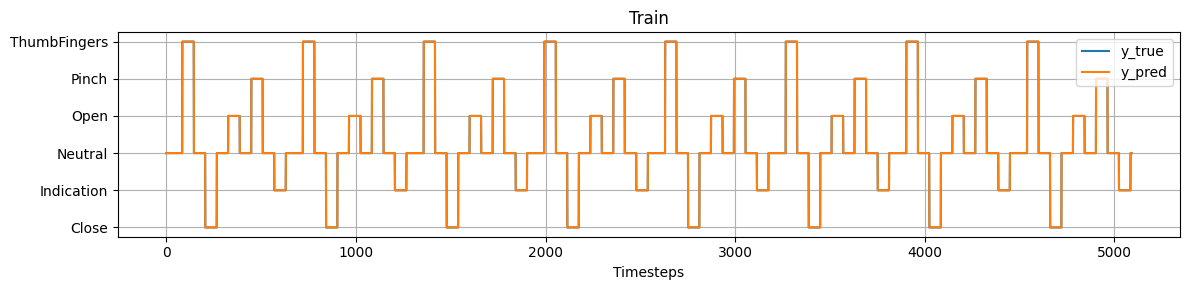

In [48]:
fig = plt.figure(figsize=(12, 3))
plt.plot(y_train, label='y_true')
plt.plot(preds_train, label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Train')
plt.tight_layout()

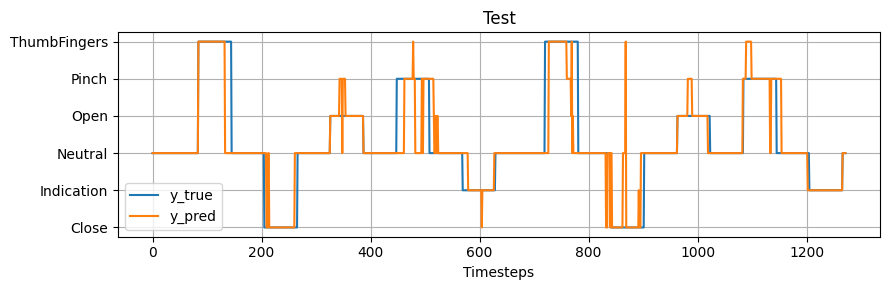

In [49]:
fig = plt.figure(figsize=(9, 3))
plt.plot(y_valid, label='y_true')
plt.plot(preds_valid, label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Test')
plt.tight_layout()

## Metrics

In [50]:
print('Train preds metrics report:')
print(metrics.classification_report(
    y_train, preds_train, target_names=GESTURES, digits=4, zero_division=0))
print('-'*55)
print('Test preds metrics report:')
print(metrics.classification_report(
    y_valid, preds_valid, target_names=GESTURES, digits=4, zero_division=0))

# создаём таблицу сопряжённости
ct = pd.crosstab(y_valid, preds_valid.reshape(-1))
if not list(ct.index) == list(ct.columns):
    set1, set2 = set(ct.index), set(ct.columns)
    diff = set1.difference(set2)
    if len(diff) == 1:
        specific_index = list(ct.index).index(list(diff)[0])
        new_column_name = str(diff)
        ct.insert(specific_index, new_column_name, 0)
        # определяем название активностей
        ct.index = ct.columns = GESTURES
        display(ct)
    else:
        print('Более чем один жест моделью не распознается!')
else:
    ct.index = ct.columns = GESTURES
    display(ct)

Train preds metrics report:
              precision    recall  f1-score   support

       Close     1.0000    1.0000    1.0000       485
  Indication     1.0000    1.0000    1.0000       486
     Neutral     1.0000    1.0000    1.0000      2667
        Open     1.0000    1.0000    1.0000       486
       Pinch     1.0000    1.0000    1.0000       484
ThumbFingers     1.0000    1.0000    1.0000       484

    accuracy                         1.0000      5092
   macro avg     1.0000    1.0000    1.0000      5092
weighted avg     1.0000    1.0000    1.0000      5092

-------------------------------------------------------
Test preds metrics report:
              precision    recall  f1-score   support

       Close     0.9505    0.7869    0.8610       122
  Indication     0.9643    0.8926    0.9270       121
     Neutral     0.8651    0.9549    0.9078       665
        Open     0.9333    0.8099    0.8673       121
       Pinch     0.6480    0.6694    0.6585       121
ThumbFingers     0.87

,Close,Indication,Neutral,Open,Pinch,ThumbFingers
Close,96,1,24,0,0,1
Indication,1,108,12,0,0,0
Neutral,4,3,635,5,18,0
Open,0,0,5,98,18,0
Pinch,0,0,29,0,81,11
ThumbFingers,0,0,29,2,8,83


---

# Real-time inference

## Inference Utils: Put your code here

In [58]:
def preprocessing(x, prev, sample_size=10, n_ftrs=5, alpha=0.5):
    # x - sample vector
    if prev is None:
        # x = np.delete(x.reshape(1, -1), bad_features, axis=1)
        prev = x.reshape(1, -1)
        # prev_scaled = std_scaler.transform(prev)
        # prev_approx = get_sliding_approximation(prev_scaled, n_ftrs=n_ftrs)
        prev_ar = create_AR_features(prev, p=n_ftrs)
        prev_ = np.hstack((prev, prev_ar)) # prev_scaled, 
        # prev_pca = pca.transform(prev)
        # prev_pca = pca.transform(prev_scaled)
        y = prev_
    else:
        # x = np.delete(x.reshape(1, -1), bad_features, axis=1)
        prev = np.vstack((prev, x.reshape(1, -1)))
        if prev.shape[0] < sample_size:
            # prev_scaled = std_scaler.transform(prev)
            # prev_approx = get_sliding_approximation(prev_scaled, n_ftrs=n_ftrs)
            prev_ar = create_AR_features(prev, p=n_ftrs)
            prev_ = np.hstack((prev, prev_ar)) # prev_scaled, 
            # prev_pca = pca.transform(prev)
            # prev_pca = pca.transform(prev_ar)
            # prev_pca = pca.transform(prev_scaled)
            y = get_convolve(prev_, M=10, tau=3, sym=True)[-1]
            # y = get_smoothing(pd.DataFrame(prev_), sample_size=prev.shape[0], alpha=alpha)[-1]
            # y = prev_[-1]
        else:
            volume = sample_size + n_ftrs
            if prev.shape[0] < volume:
                prev = np.vstack((np.zeros((volume - prev.shape[0], prev.shape[1])), prev))
                appr_prev = prev[:n_ftrs]
                prev_x = prev[n_ftrs:]
            else:
                prev = prev[1:]
                appr_prev = prev[:n_ftrs]
                prev_x = prev[n_ftrs:]
            # prev_scaled = std_scaler.transform(prev_x)
            # prev_approx = get_sliding_approximation(
            #     prev_scaled, n_ftrs=5, prev=appr_prev)
            prev_ar = create_AR_features(prev_x, p=n_ftrs, prev=appr_prev)
            prev_ = np.hstack((prev_x, prev_ar)) # prev_scaled, 
            # prev_pca = pca.transform(prev_x)
            # prev_pca = pca.transform(prev_scaled)
            y = get_convolve(prev_, M=10, tau=3, sym=True)[-1]
            # y = get_smoothing(pd.DataFrame(prev_), sample_size=prev_x.shape[0], alpha=alpha)[-1]
            # y = prev_[-1]
            
    return y.reshape(1, -1), prev


def inference(x):
    # y = model.predict_proba([x])[0]
    y = model.predict(x)
    
    return y


def postprocessing(x, prev, length=5):
    # if prev is None:
    #     y = x
    # else:
    #     y = x*0.1 + prev*0.9 # Holt-Winters filter

    if prev is None:
        prev = np.zeros((length,))
        prev[0] = x
        prev = prev.astype(int)
        counts = np.bincount(prev)
        y = np.argmax(counts)
    else:
        prev[1:] = prev[:-1]
        prev[0] = x
        prev = prev.astype(int)
        counts = np.bincount(prev)
        y = np.argmax(counts)
        
    return y, prev


def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    
    return y


# def commands(x):
#     cmd = vp.neutral_state.copy()
#     # for this mapping look at GESTURES
#     if x == 0: # 'Close'
#         cmd.update({'thumb_flex': 1, 'index_flex': 1, 'middle_flex': 1, 'ring_flex': 1, 'pinky_flex': 1})
#         return cmd
#     elif x == 1: # 'Indication'
#         cmd.update({'thumb_extend':1, 'index_extend': 1, 'middle_flex': 1, 'ring_flex': 1, 'pinky_flex': 1})
#         return cmd
#     elif x == 2: # 'Neutral'
#         pass
#         return cmd
#     elif x == 3: # 'Open'
#         cmd.update({'thumb_extend': 1, 'index_extend': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
#         return cmd
#     elif x == 4: # 'Pinch'
#         cmd.update({'thumb_flex':1, 'index_flex': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
#         return cmd
#     elif x == 5: # 'ThumbFingers'
#         cmd.update({'thumb_flex': 1, 'index_extend': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
#         return cmd
#     else:
#         return cmd

## Inference

### Offline (dataset)

In [64]:
# df_sim = gestures.iloc[:, :52][1950:]
# target = y_shifted[1950:]

df_sim = gestures.iloc[:, :52][int(X.shape[0] * 0.8)+1:]
target = y_shifted[int(X.shape[0] * 0.8)+1:]

print(df_sim.shape, target.shape)

(1272, 52) (1272,)


In [54]:
# Отключаем предупреждения DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)

Текст предупреждения:<br>*DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)*

Строка кода, вызывающее предупреждение:<br>`prev[0] = x`

In [65]:
sample = df_sim.values[0]
[[ts, cycle_ts], omg_sample] = np.array_split(sample, [2])
sample_preprocessed, x_previous = preprocessing(omg_sample, None)
y_predicted = inference(sample_preprocessed)
y_postprocessed, y_previous = postprocessing(y_predicted, None, length=5)
y_previous

array([2, 0, 0, 0, 0])

In [73]:
LENGTH = 5

ts_diffs = []
x_previous = None

In [74]:
TIMEOUT = 0.2
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [[ts, cycle_ts], omg_sample] = np.array_split(sample, [2])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed, x_previous = preprocessing(omg_sample, x_previous)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed, y_previous = postprocessing(y_predicted, y_previous, length=LENGTH)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands = commands(y_postprocessed.argmax())
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    # y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=52, OMG=50
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}')
        # print('INPUT:\n', s)
        print('SAMPLE:\n', sample)

        # sanity check: Sizes of SAMPLE=65, OMG=50
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}')
        print(f'TS: {ts}, CYCLE TS: {cycle_ts}')
        print(y_postprocessed)
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), f'Calculation cycle takes more than TIMEOUT, halting...\n{ts_diff}'
    ts_old = ts_start
    ts_diffs.append(ts_diff)
    i += 1 

In [75]:
np.max(ts_diffs)

0.01900005340576172

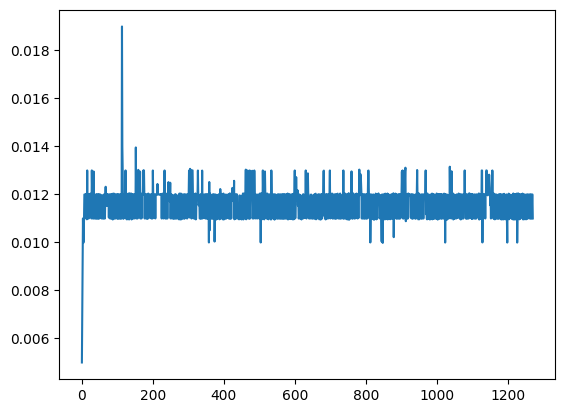

In [76]:
pd.Series(ts_diffs).plot();

In [77]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (1272, 50)
sample_preprocessed.shape = (1272, 1, 350)
y_predicted.shape = (1272, 1, 1)
y_postprocessed.shape = (1272,)
y_commands.shape = (1272,)


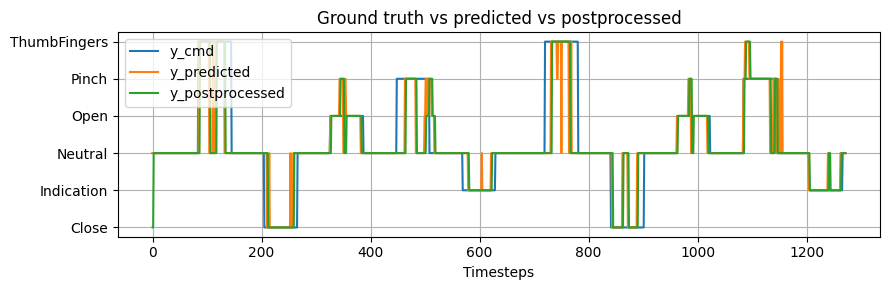

In [78]:
fig = plt.figure(figsize=(9, 3))

plt.plot(target, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'].reshape(-1), c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')

plt.title('Ground truth vs predicted vs postprocessed')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [79]:
print(metrics.classification_report(
    target, y_dct['y_postprocessed'],
    target_names=GESTURES, digits=4,
    zero_division=0
))

# создаём таблицу сопряжённости
ct = pd.crosstab(y_valid, np.array(y_dct['y_postprocessed']).reshape(-1))
if not list(ct.index) == list(ct.columns):
    set1, set2 = set(ct.index), set(ct.columns)
    diff = set1.difference(set2)
    if len(diff) == 1:
        specific_index = list(ct.index).index(list(diff)[0])
        new_column_name = str(diff)
        ct.insert(specific_index, new_column_name, 0)
        # определяем название активностей
        ct.index = ct.columns = GESTURES
        display(ct)
    else:
        print('Более чем один жест моделью не распознается!')
else:
    ct.index = ct.columns = GESTURES
    display(ct)

              precision    recall  f1-score   support

       Close     0.9767    0.6885    0.8077       122
  Indication     1.0000    0.8017    0.8899       121
     Neutral     0.7888    0.9774    0.8731       665
        Open     0.8942    0.7686    0.8267       121
       Pinch     0.7619    0.5289    0.6244       121
ThumbFingers     0.8961    0.5656    0.6935       122

    accuracy                         0.8310      1272
   macro avg     0.8863    0.7218    0.7859      1272
weighted avg     0.8447    0.8310    0.8231      1272



,Close,Indication,Neutral,Open,Pinch,ThumbFingers
Close,84,0,38,0,0,0
Indication,0,97,24,0,0,0
Neutral,2,0,650,5,8,0
Open,0,0,16,93,12,0
Pinch,0,0,43,6,64,8
ThumbFingers,0,0,53,0,0,69
